# Libraries

In [1]:
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Data Information

In [2]:
url = 'https://drive.google.com/file/d/12jWvnJLqwZmSw3fnrXpQm25o7V2u5IHa/view?usp=drive_link'

train_file_id = url.split('/')[-2]

dwn_url = 'https://drive.google.com/uc?id=' + train_file_id

gdown.download(dwn_url, 'train.csv', quiet=False)

df = pd.read_csv('train.csv')

Downloading...
From: https://drive.google.com/uc?id=12jWvnJLqwZmSw3fnrXpQm25o7V2u5IHa
To: /content/train.csv
100%|██████████| 78.2k/78.2k [00:00<00:00, 45.7MB/s]


In [3]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


# Data Preprocessing

## Time Features

In [6]:
df_model = df.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [7]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5


# Exploratory Data Analysis

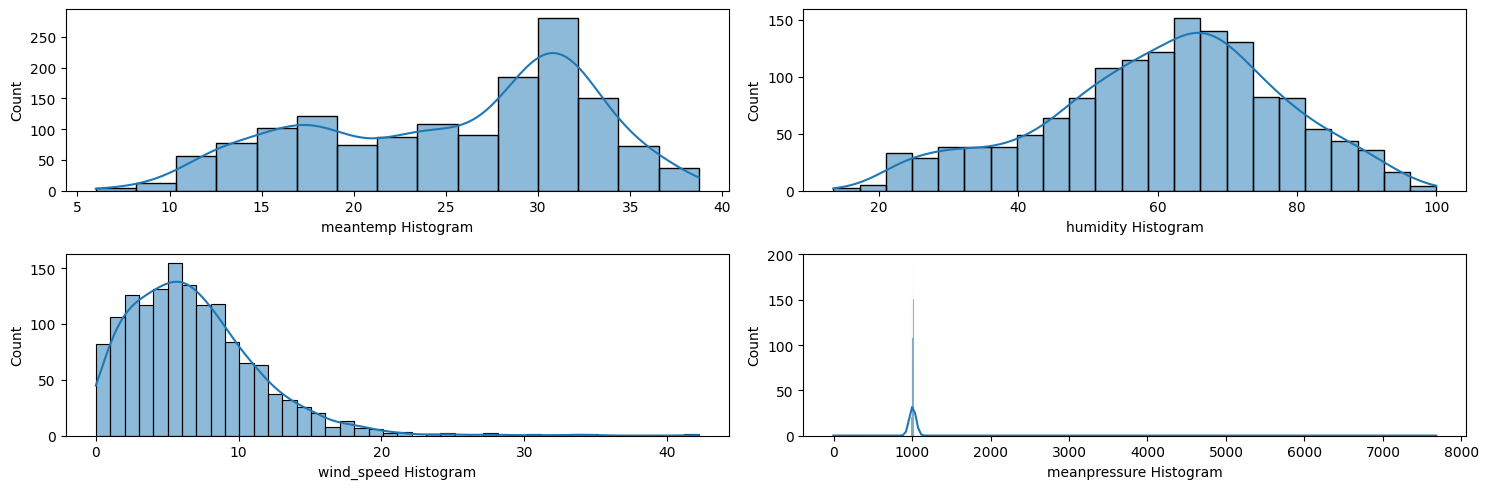

In [8]:
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
fig, axes = plt.subplots(2, 2, figsize = (15,5))
axes = axes.flatten()

for i, col in enumerate(columns):
  ax = sns.histplot(data = df, x = df[col], ax = axes[i], kde = True)
  ax.set_xlabel(f'{col} Histogram')

plt.tight_layout()
plt.show()

Line Plot by date


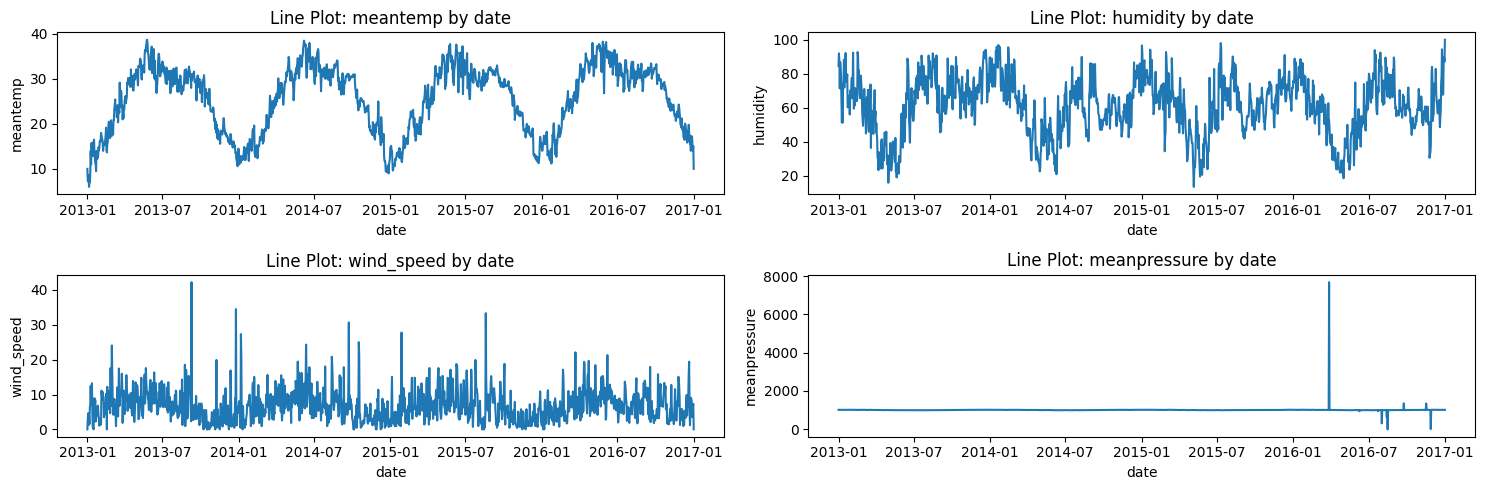





Line Plot by year


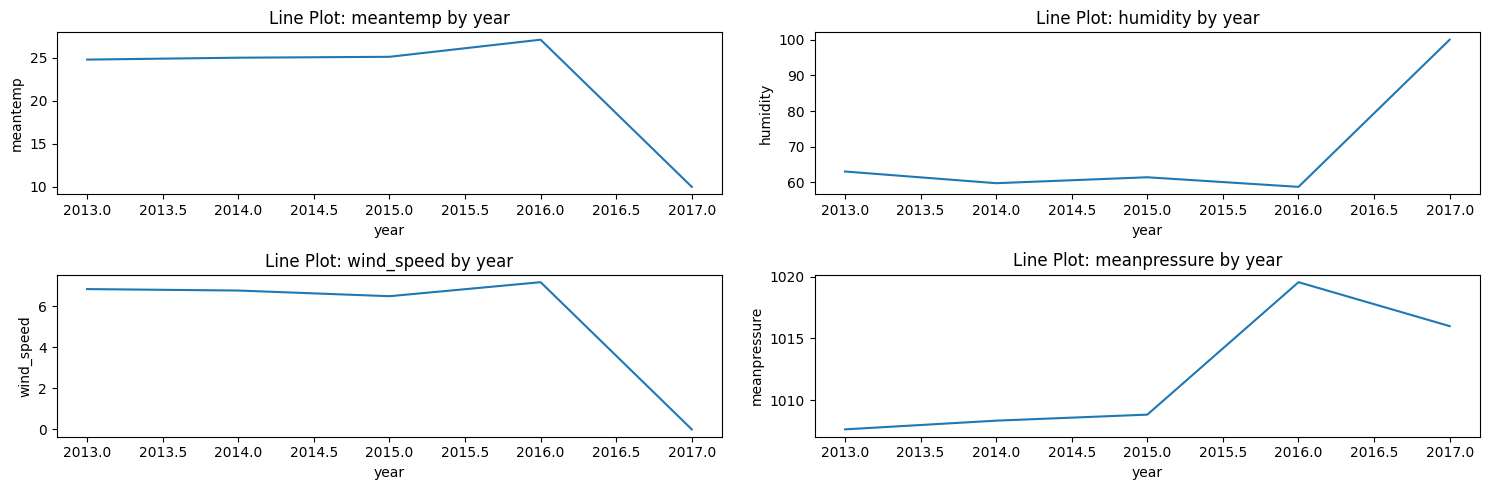





Line Plot by month


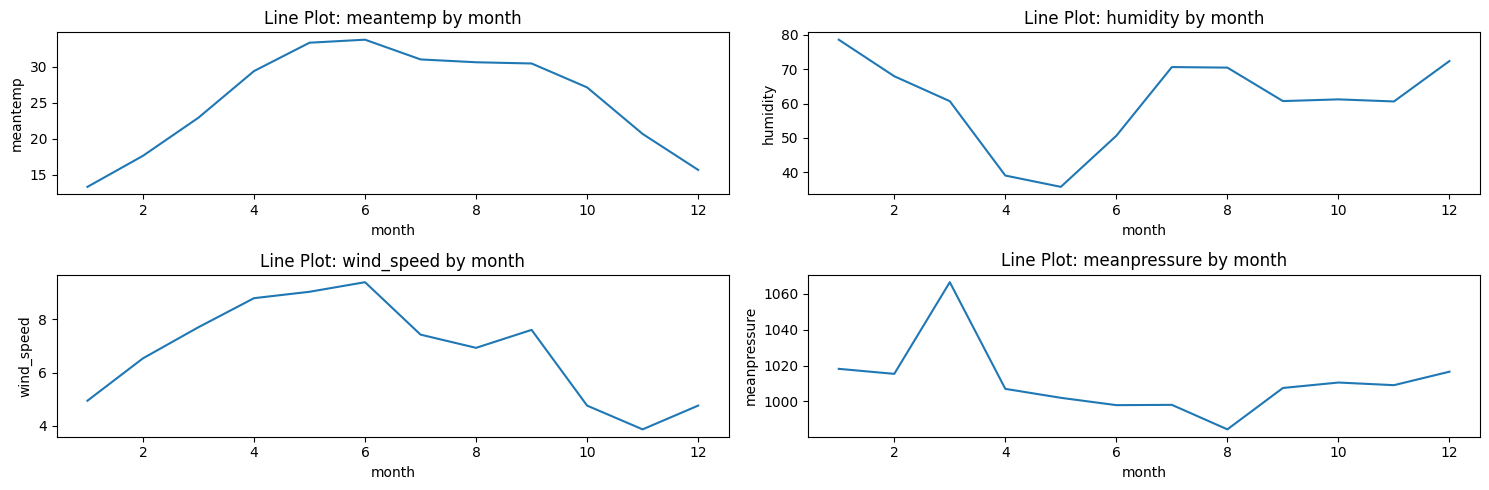





Line Plot by day


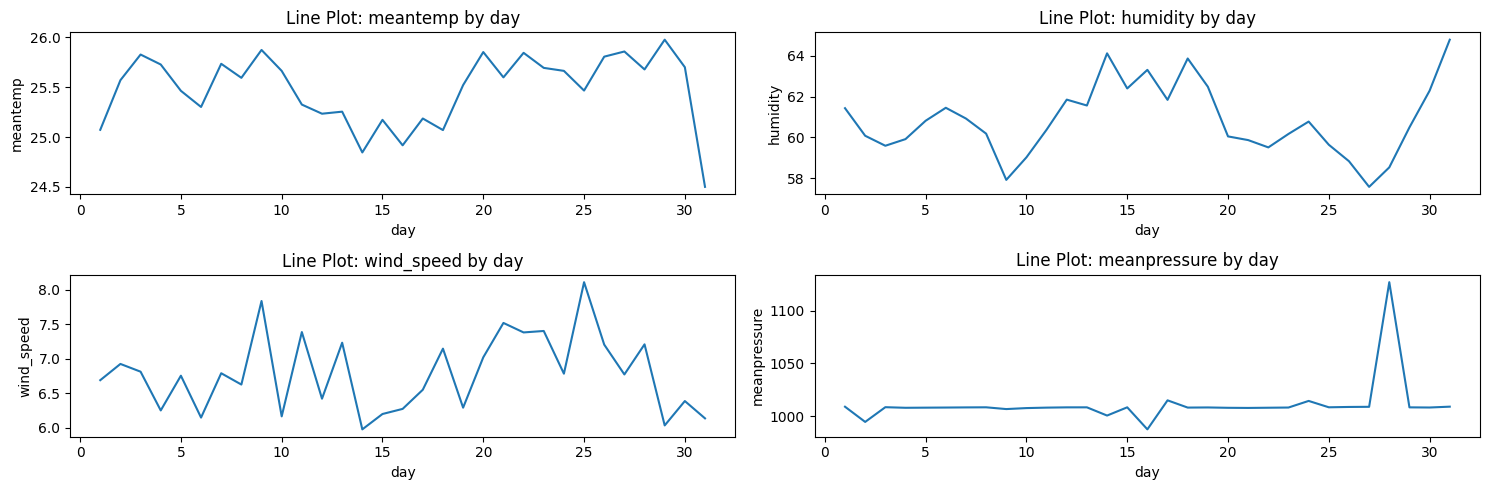

In [9]:
time_columns = ['date', 'year', 'month', 'day']

for time_col in time_columns:
  print(f"Line Plot by {time_col}")
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
  axes = axes.flatten()

  for i, col in enumerate(columns):
    ax = sns.lineplot(x=time_col, y=col, data=df, ax=axes[i], errorbar=None)
    ax.set_xlabel(time_col)
    ax.set_ylabel(col)
    ax.set_title(f'Line Plot: {col} by {time_col}')

  plt.tight_layout()
  plt.show()
  print("\n\n\n")

Box Plot by year


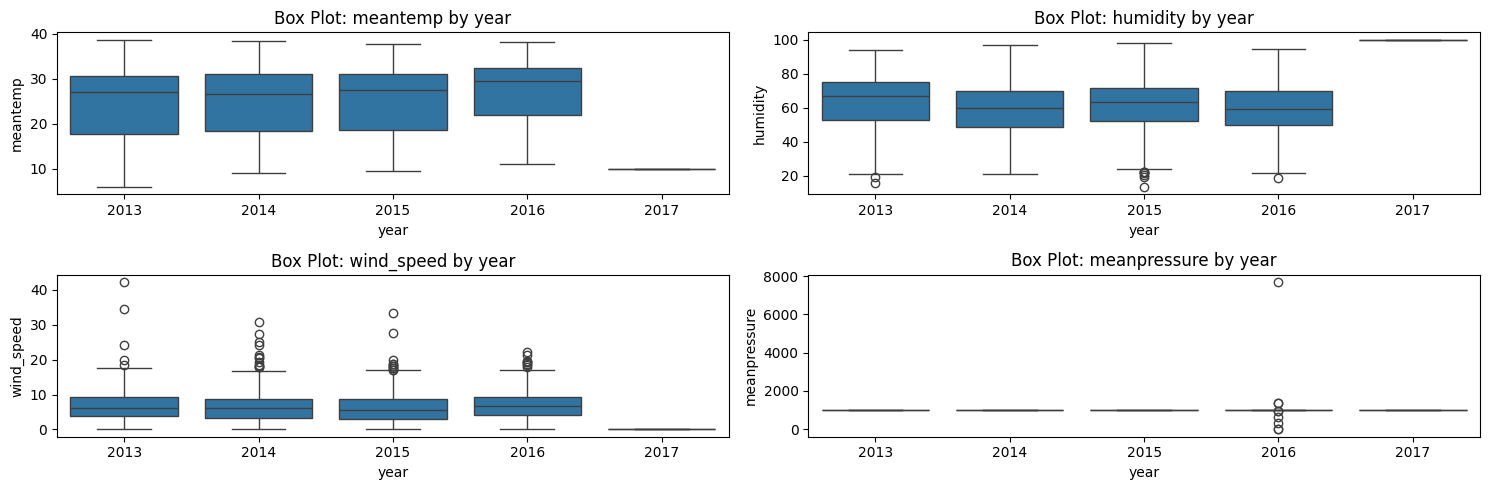





Box Plot by month


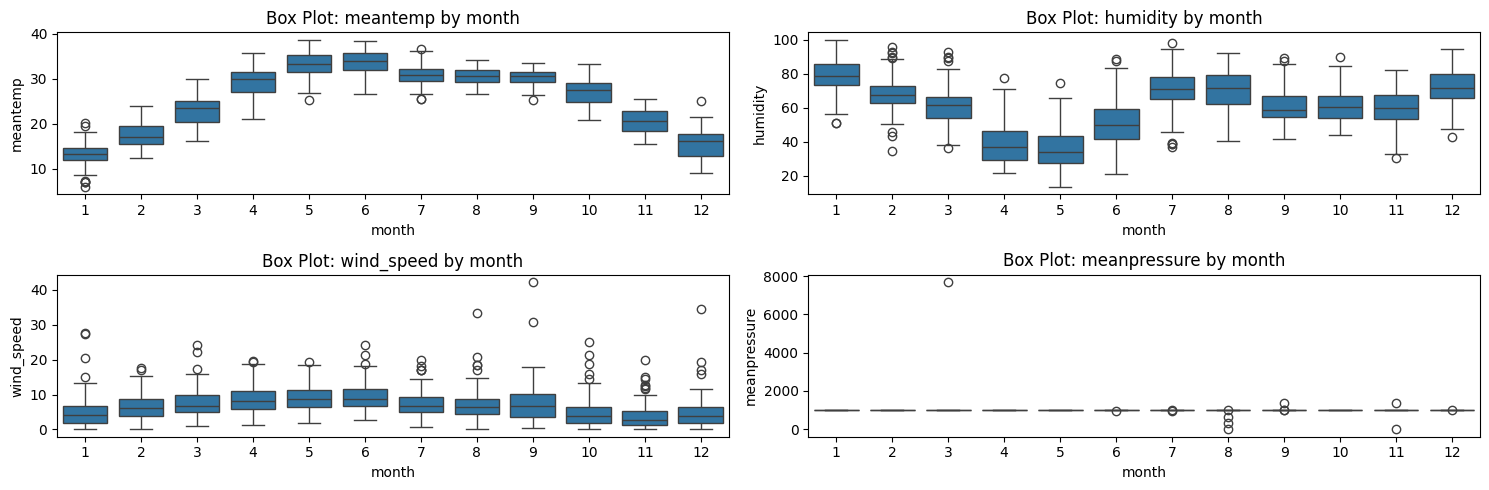

In [10]:
time_columns = ['year', 'month']

for time_col in time_columns:
  print(f"Box Plot by {time_col}")
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
  axes = axes.flatten()

  for i, col in enumerate(columns):
    ax = sns.boxplot(data = df, x = time_col , y = col, ax = axes[i])
    ax.set_xlabel(time_col)
    ax.set_ylabel(col)
    ax.set_title(f'Box Plot: {col} by {time_col}')

  plt.tight_layout()
  plt.show()
  print("\n\n\n")

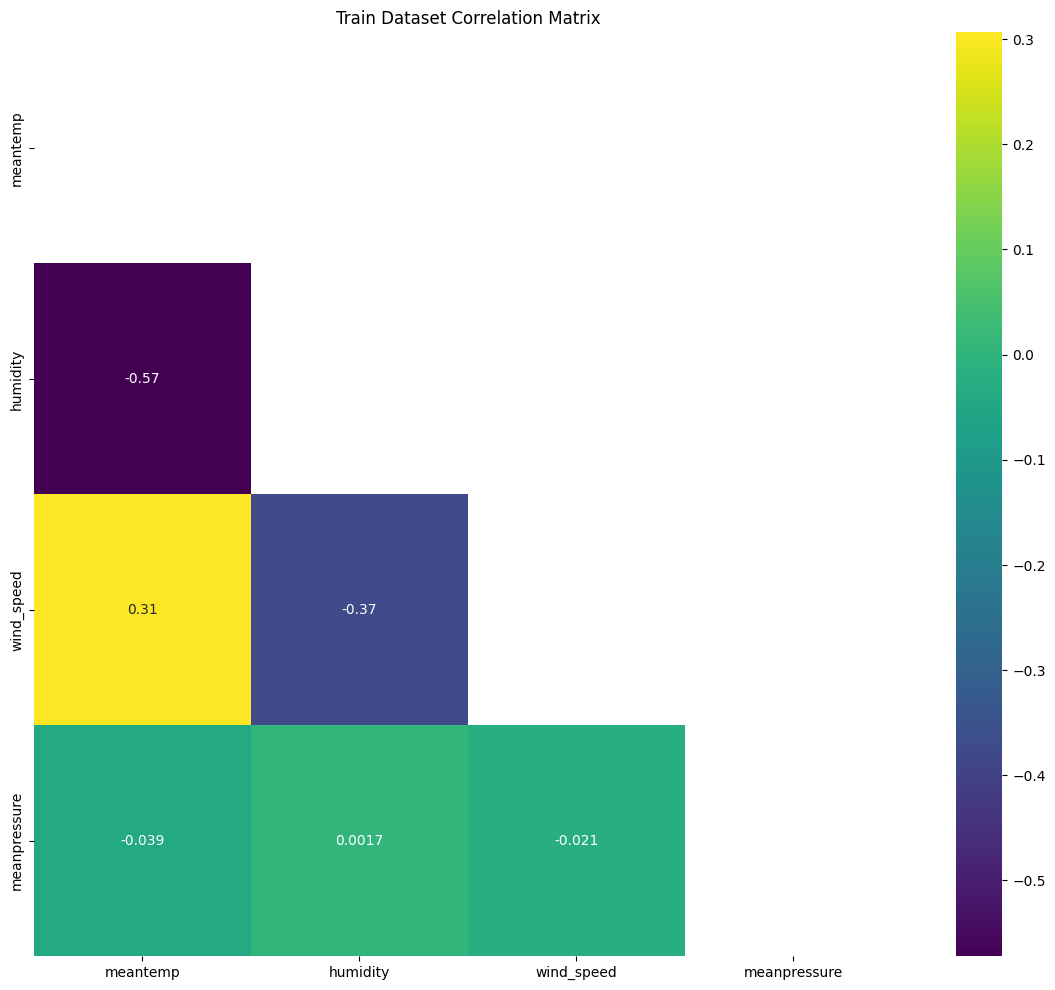

In [11]:
numerical = [col for col in df.columns if df[col].dtypes in ['float64', 'int64']]

corr = df[numerical].corr()
plt.figure(figsize=(14, 12))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='viridis', annot=True)
plt.title('Train Dataset Correlation Matrix')
plt.show()

# Decomposition

Decomposition adalah teknik dalam analisis time series yang memecah data time series menjadi beberapa komponen, yang masing-masing mewakili pola dasar. Tujuannya adalah untuk membuat data lebih mudah dianalisis dan diinterpretasikan. Komponen-komponen tersebut biasanya meliputi:

Trend (Tren): Komponen ini mewakili perkembangan atau pergerakan jangka panjang dalam data. Ini menunjukkan arah keseluruhan di mana data bergerak seiring waktu, apakah meningkat, menurun, atau tetap konstan.

Seasonal (Musiman): Komponen ini menangkap pola atau siklus yang berulang dalam data yang terjadi pada interval reguler, seperti siklus harian, mingguan, bulanan, atau tahunan. Ini mencerminkan fluktuasi periodik.

Residual (Irregular) (Residu atau Tidak Teratur): Komponen ini mencakup variasi acak atau tidak teratur dalam data yang tidak dapat dijelaskan oleh tren atau komponen musiman. Ini sering mewakili kebisingan atau kesalahan acak.

Observed (Diamati): Data asli sebelum decomposisi.

Decomposition membantu dalam memahami struktur dasar dari time series dan mendukung dalam peramalan (forecasting), deteksi anomali, dan pemodelan yang lebih baik.

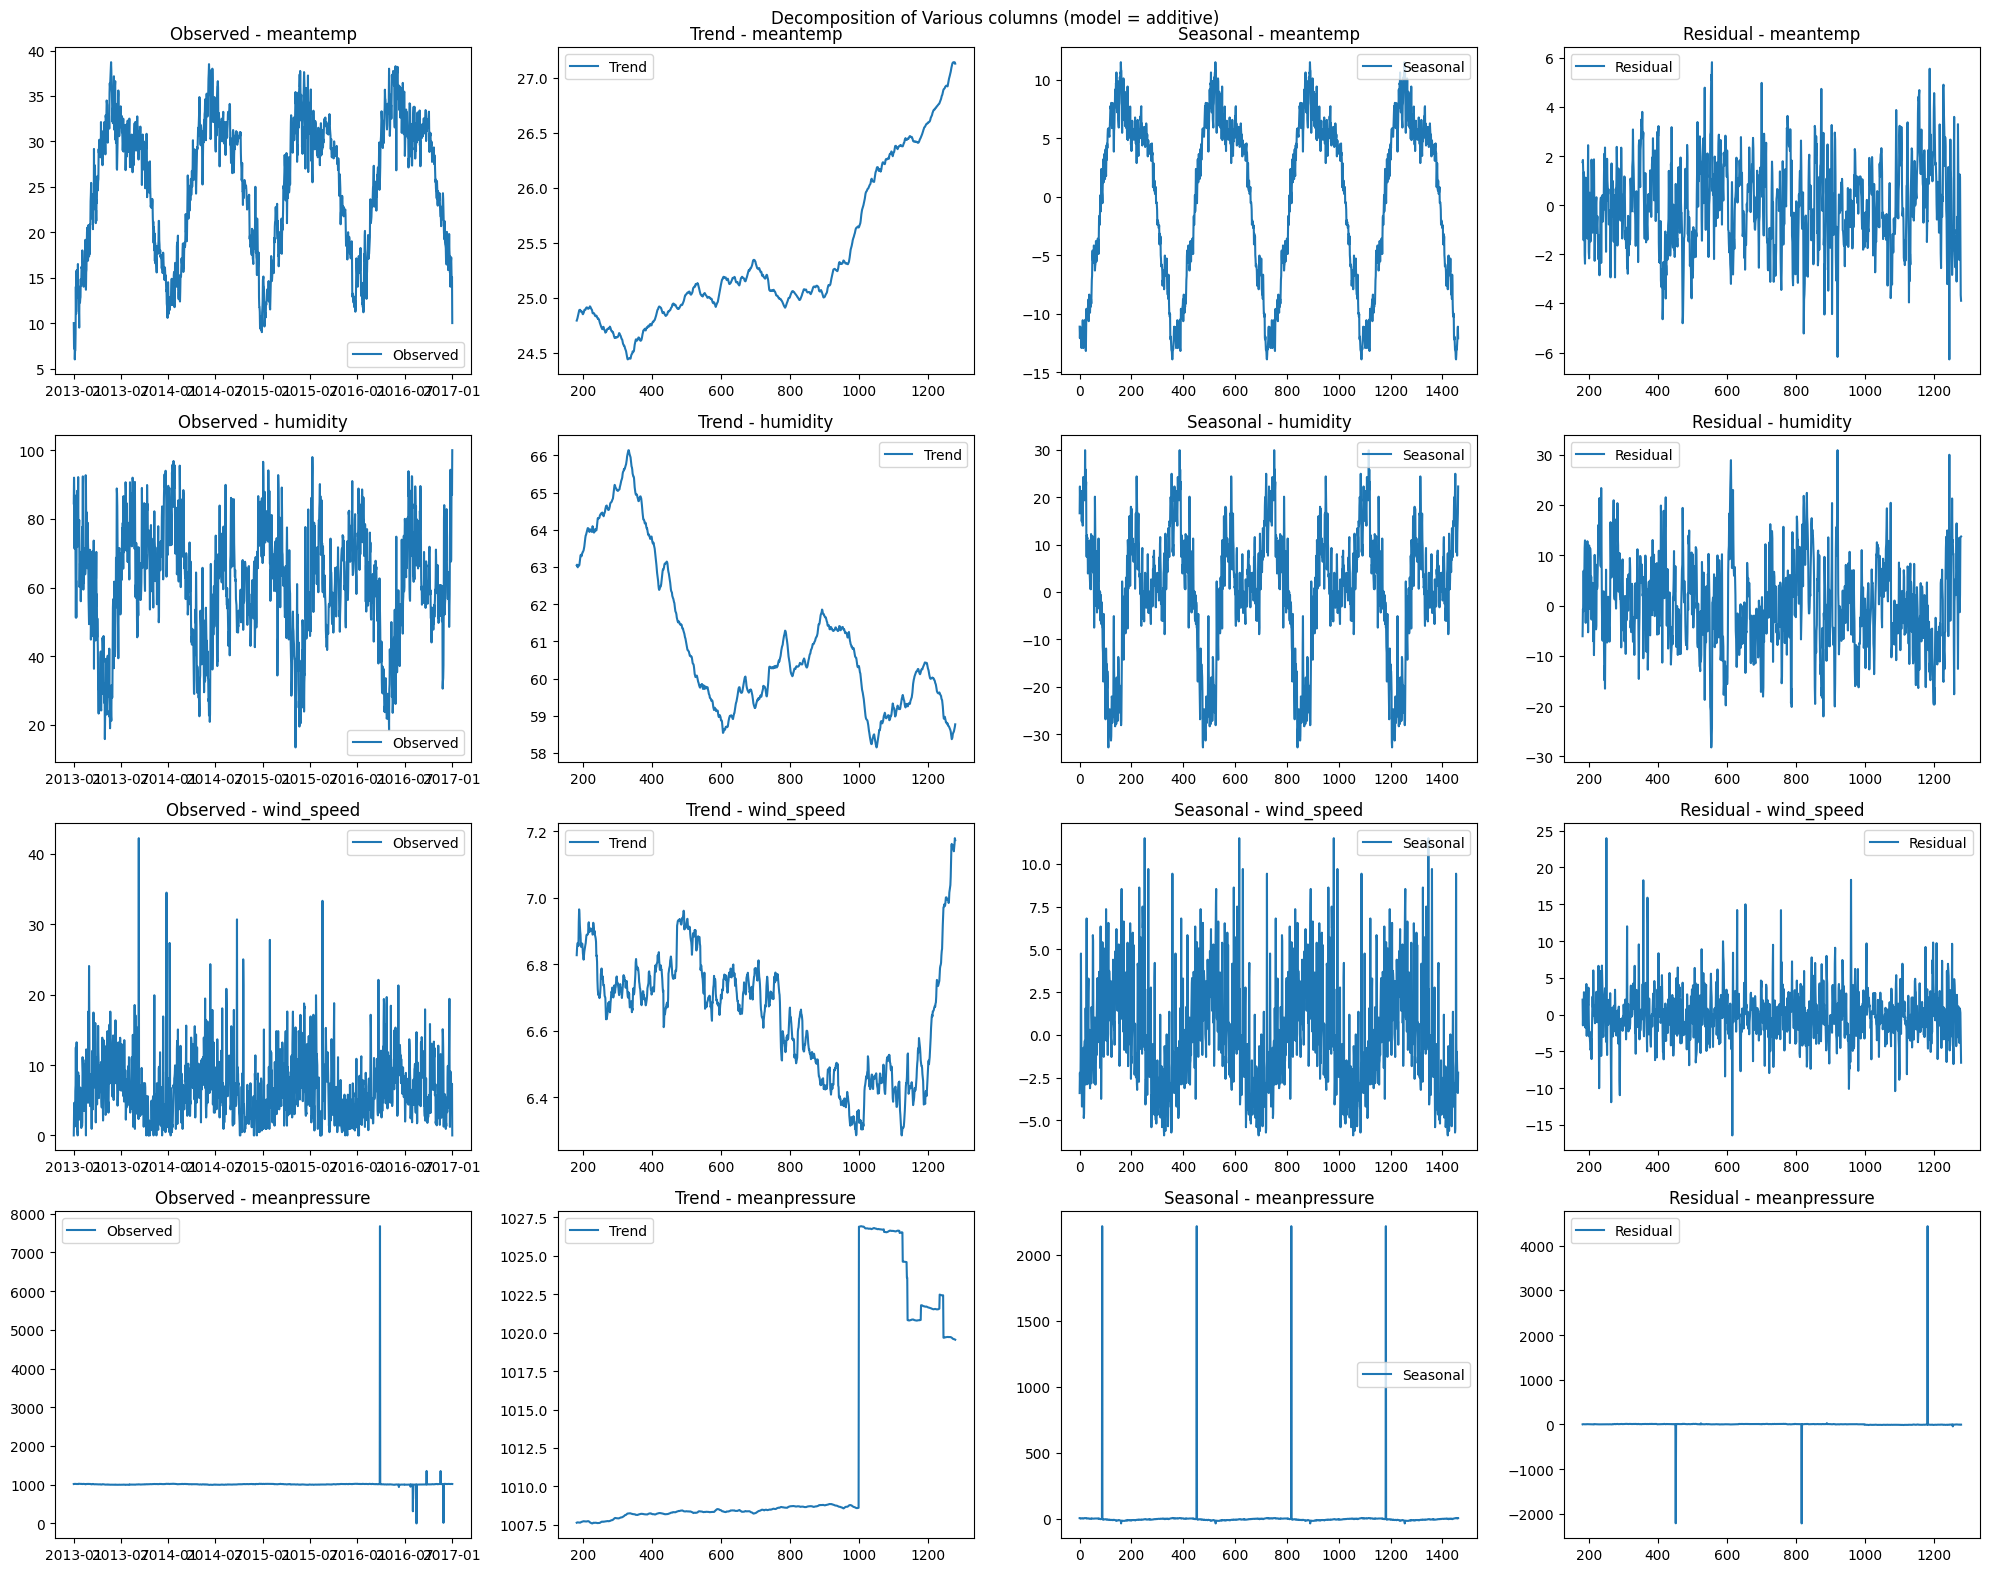

In [12]:
df.set_index('date', inplace = True)
fig, axes = plt.subplots(nrows = len(columns), ncols = 4, figsize = (20, 4 * len(columns)))

for i, col in enumerate(columns):
  daily_data = df[col].resample('D').sum()
  decomposition = seasonal_decompose(daily_data.values, period = 365, model = 'additive')

  axes[i, 0].plot(daily_data, label = 'Observed')
  axes[i, 0].legend(loc = 'best')
  axes[i, 0].set_title(f'Observed - {col}')

  axes[i, 1].plot(decomposition.trend, label = 'Trend')
  axes[i, 1].legend(loc = 'best')
  axes[i, 1].set_title(f'Trend - {col}')

  axes[i, 2].plot(decomposition.seasonal, label = 'Seasonal')
  axes[i, 2].legend(loc = 'best')
  axes[i, 2].set_title(f'Seasonal - {col}')

  axes[i, 3].plot(decomposition.resid, label = 'Residual')
  axes[i, 3].legend(loc = 'best')
  axes[i, 3].set_title(f'Residual - {col}')

plt.suptitle('Decomposition of Various columns (model = additive)')
plt.tight_layout()
plt.show()

# Checking Stationary
## Autocorrelation (ACF) and Partial Autocorrelation (PACF)

Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF) adalah alat penting dalam analisis deret waktu. Keduanya digunakan untuk memahami hubungan dalam data deret waktu dan untuk menentukan parameter model ARIMA yang optimal. Mari kita lihat fungsi dan cara penggunaan keduanya dalam konteks model ARIMA:

Fungsi ACF dan PACF
Autocorrelation Function (ACF):

Fungsi: ACF mengukur kekuatan hubungan antara nilai seri waktu dengan nilai-nilai di lags tertentu. Ini menunjukkan seberapa banyak nilai seri waktu saat ini dipengaruhi oleh nilai sebelumnya pada lag tertentu.
Penggunaan: ACF digunakan untuk melihat struktur periodik dalam data dan untuk menentukan parameter q (jumlah komponen MA, Moving Average) dalam model ARIMA.
Partial Autocorrelation Function (PACF):

Fungsi: PACF mengukur kekuatan hubungan antara nilai seri waktu dengan nilai-nilai di lags tertentu, setelah menghilangkan pengaruh dari lags-lags yang lebih kecil. Ini menunjukkan hubungan langsung antara nilai saat ini dengan nilai di lag tertentu tanpa pengaruh dari lags yang lebih kecil.
Penggunaan: PACF digunakan untuk menentukan parameter p (jumlah komponen AR, AutoRegressive) dalam model ARIMA.

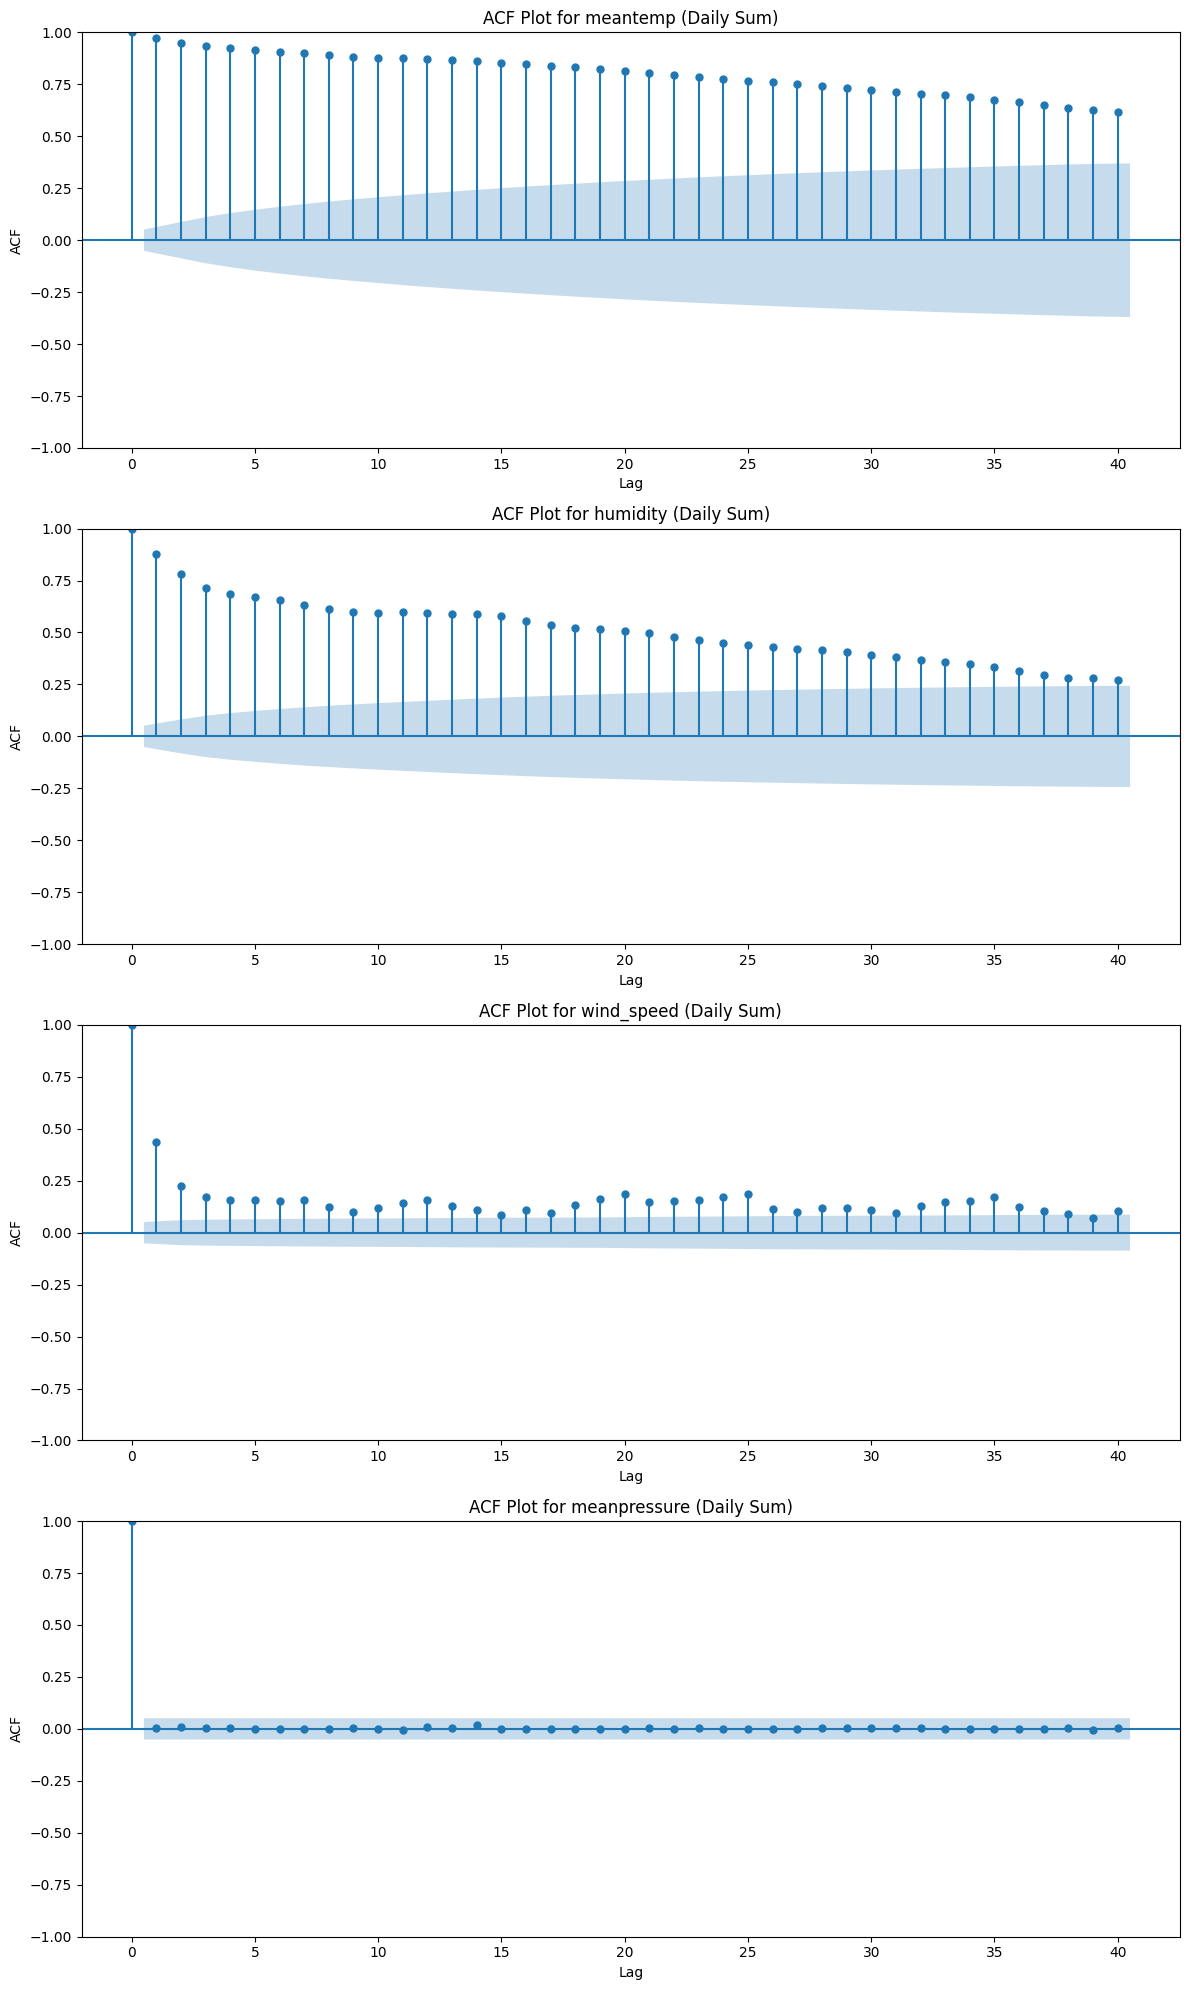

In [13]:
fig, axes = plt.subplots(nrows = len(columns), ncols = 1, figsize = (12, 20))
axes = axes.flatten()

daily_data = df[columns].resample('D').sum()
for i, col in enumerate(columns):
  ax = axes[i]
  plot_acf(x = daily_data[col], ax = ax , lags = 40)
  ax.set_title(f'ACF Plot for {col} (Daily Sum)')
  ax.set_xlabel('Lag')
  ax.set_ylabel('ACF')

plt.tight_layout()
plt.show()

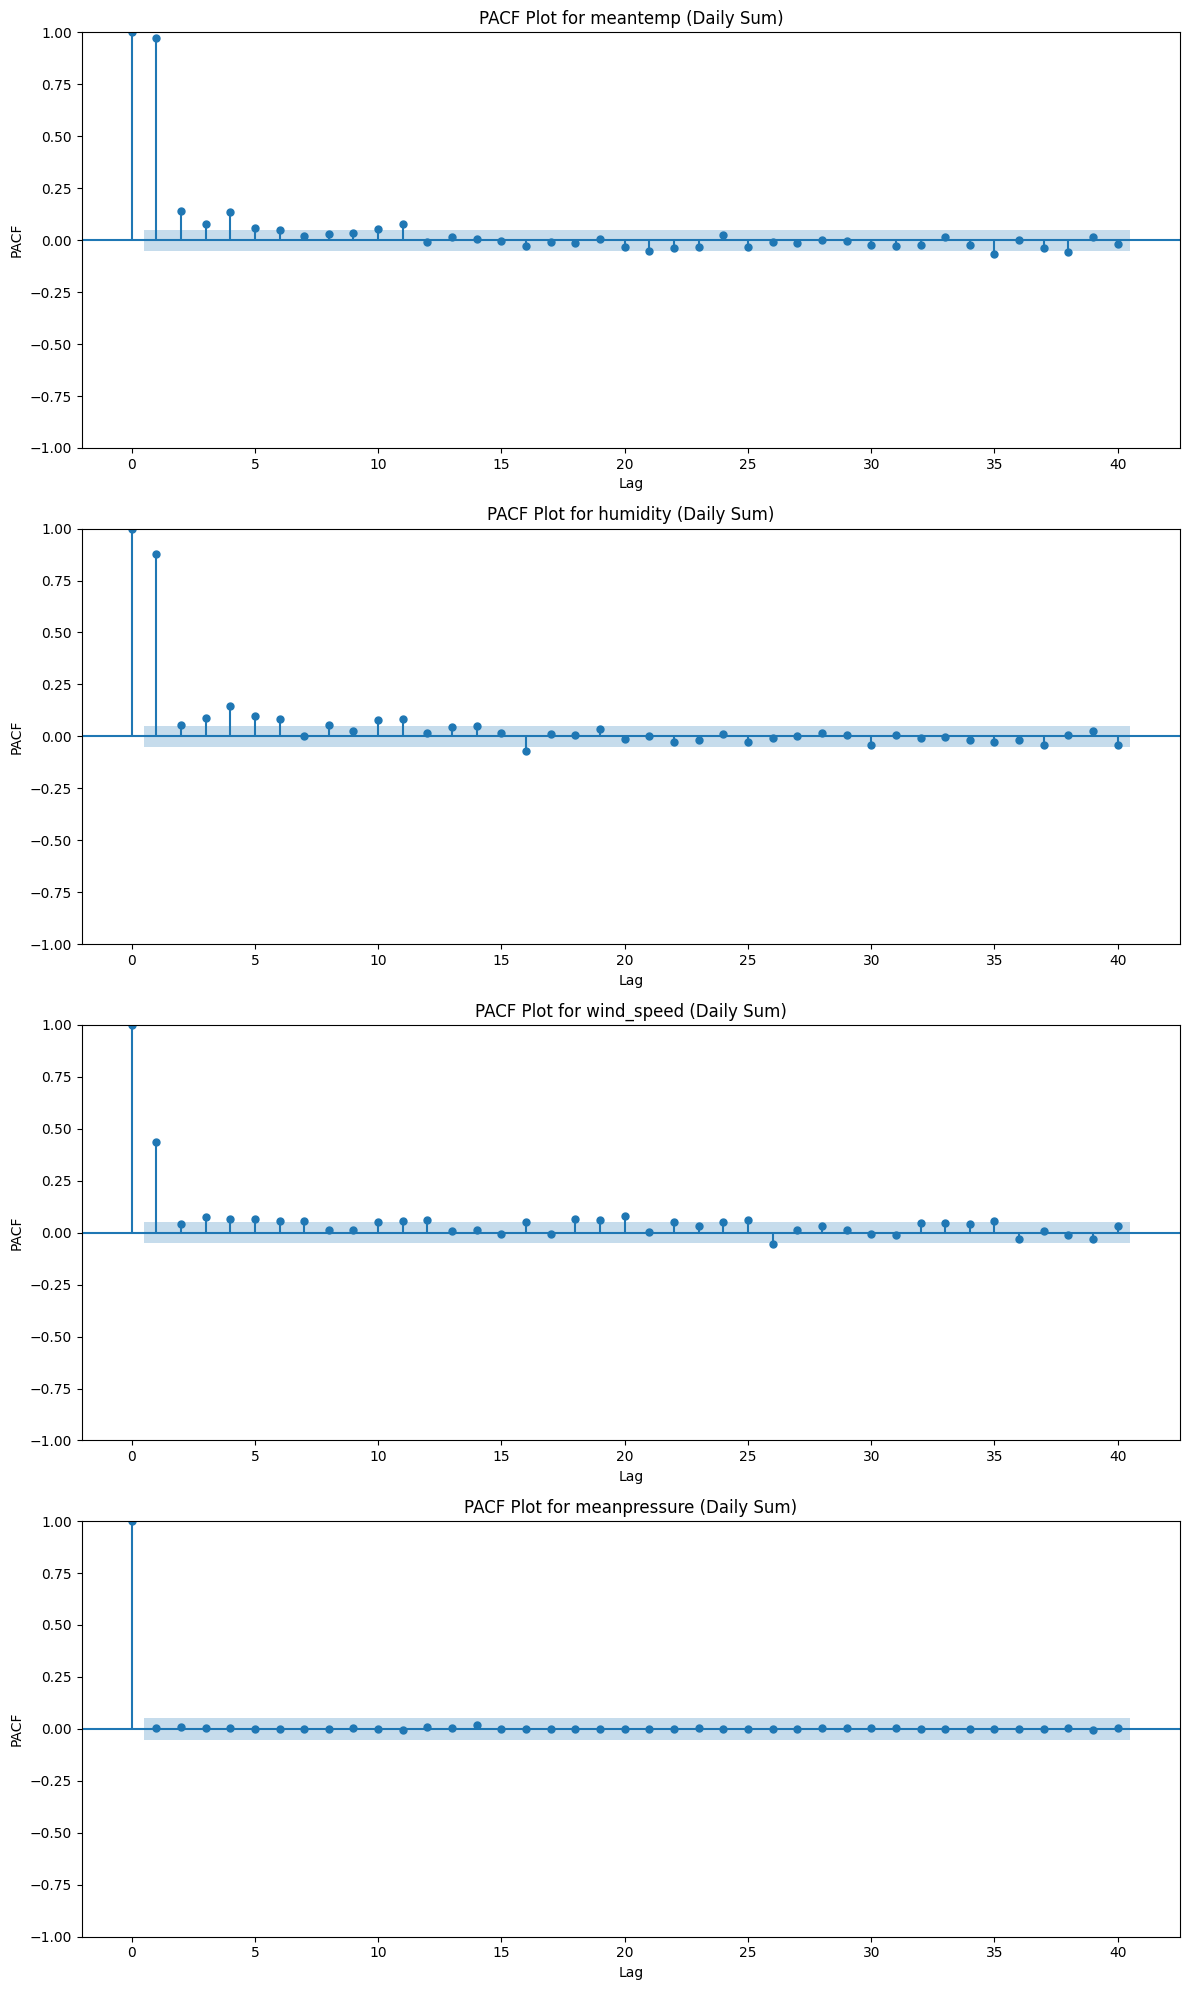

In [14]:
fig, axes = plt.subplots(nrows = len(columns), ncols = 1, figsize = (12,20))

for i, col in enumerate(columns):
  ax = axes[i]
  plot_pacf(x= daily_data[col], ax = ax, lags = 40)
  ax.set_title(f'PACF Plot for {col} (Daily Sum)')
  ax.set_xlabel('Lag')
  ax.set_ylabel('PACF')

plt.tight_layout()
plt.show()

# ADF Test

In [15]:
GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m'

for col in columns:
  print(f"Augmented Dickey-Fuller test result for: {col}")
  result = adfuller(df[col], autolag='AIC')

  print(f"ADF test statistic: {result[0]}")
  print(f"p-value: {result[1]}")

  print("Critical Values:")
  for key, val in result[4].items():
    print("\t%s : %f" % (key, val))

  if result[1] > 0.05:
    print(RED + "Series is not stationary. Further differencing is needed.\n" + RESET)
  else:
    print(GREEN + "Series is stationary. No further differencing is required.\n" + RESET)

Augmented Dickey-Fuller test result for: meantemp
ADF test statistic: -2.0210690559206737
p-value: 0.2774121372301601
Critical Values:
	1% : -3.434865
	5% : -2.863534
	10% : -2.567832
Series is not stationary. Further differencing is needed.

Augmented Dickey-Fuller test result for: humidity
ADF test statistic: -3.675576919163339
p-value: 0.004470100478130758
Critical Values:
	1% : -3.434880
	5% : -2.863541
	10% : -2.567835
Series is stationary. No further differencing is required.

Augmented Dickey-Fuller test result for: wind_speed
ADF test statistic: -3.838096756685109
p-value: 0.0025407221531463645
Critical Values:
	1% : -3.434909
	5% : -2.863553
	10% : -2.567842
Series is stationary. No further differencing is required.

Augmented Dickey-Fuller test result for: meanpressure
ADF test statistic: -38.07859002556161
p-value: 0.0
Critical Values:
	1% : -3.434834
	5% : -2.863520
	10% : -2.567824
Series is stationary. No further differencing is required.



# Modelling Arima

In [16]:
df = df[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
df1 = df.copy()
df1.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [17]:
df1.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [18]:
columns = ['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_diff']

df1['meantemp_diff'] = df1['meantemp'].diff().fillna(0)

for col in columns:
  print(f"Augmented Dickey-Fuller test result for: {col}")

  result = adfuller(df1[col], autolag='AIC')

  print(f"ADF test statistic: {result[0]}")
  print(f"p-value: {result[1]}")

  print("Critical Values:")
  for key, val in result[4].items():
    print("\t%s : %f" % (key, val))

  if result[1] > 0.05:
    print(RED + "Series is not stationary. Further differencing is needed.\n" + RESET)
  else:
    print(GREEN + "Series is stationary. No further differencing is required.\n" + RESET)

Augmented Dickey-Fuller test result for: meantemp
ADF test statistic: -2.0210690559206737
p-value: 0.2774121372301601
Critical Values:
	1% : -3.434865
	5% : -2.863534
	10% : -2.567832
Series is not stationary. Further differencing is needed.

Augmented Dickey-Fuller test result for: humidity
ADF test statistic: -3.675576919163339
p-value: 0.004470100478130758
Critical Values:
	1% : -3.434880
	5% : -2.863541
	10% : -2.567835
Series is stationary. No further differencing is required.

Augmented Dickey-Fuller test result for: wind_speed
ADF test statistic: -3.838096756685109
p-value: 0.0025407221531463645
Critical Values:
	1% : -3.434909
	5% : -2.863553
	10% : -2.567842
Series is stationary. No further differencing is required.

Augmented Dickey-Fuller test result for: meanpressure
ADF test statistic: -38.07859002556161
p-value: 0.0
Critical Values:
	1% : -3.434834
	5% : -2.863520
	10% : -2.567824
Series is stationary. No further differencing is required.

Augmented Dickey-Fuller test res

## Autocorrelation (ACF) and Partial Autocorrelation (PACF)

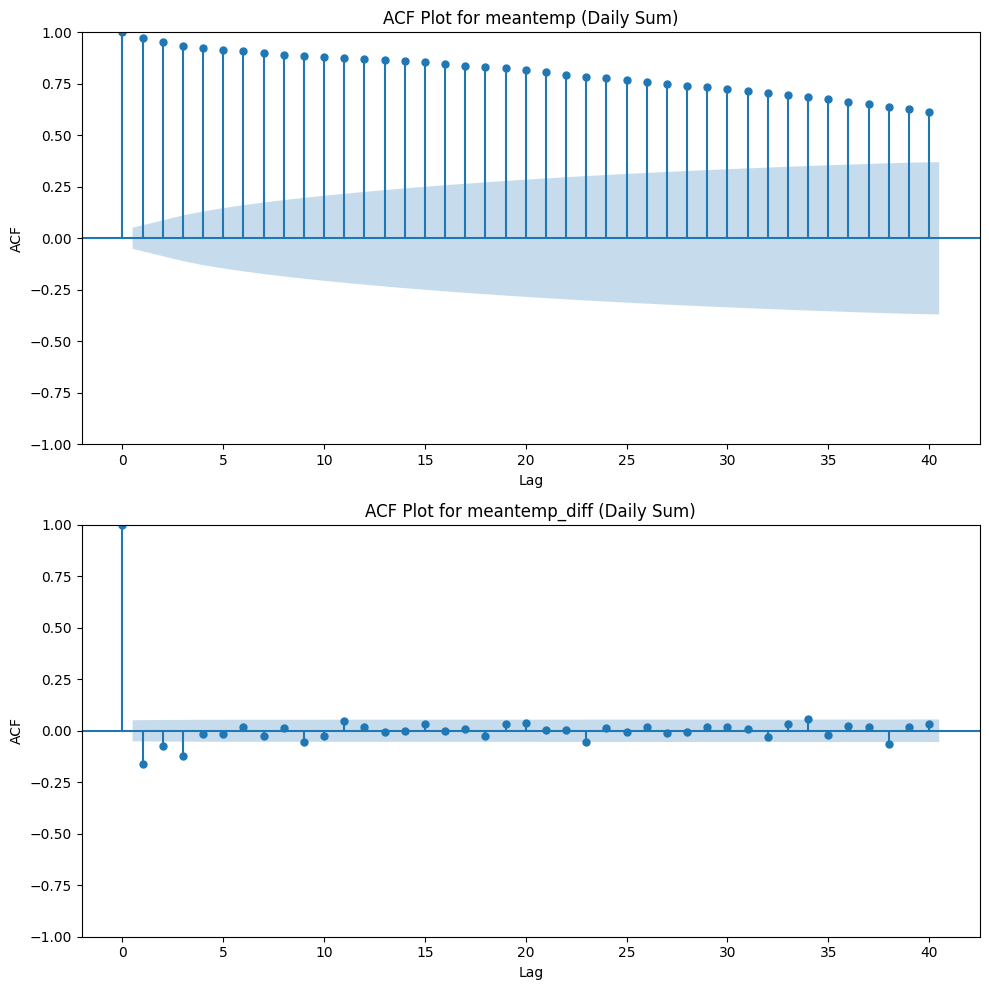

In [19]:
columns = ['meantemp', 'meantemp_diff']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 5 * len(columns)))
axes = axes.flatten()

for i, col in enumerate(columns):
  ax = axes[i]
  plot_acf(x=df1[col], ax=ax, lags=40)
  ax.set_title(f'ACF Plot for {col} (Daily Sum)')
  ax.set_xlabel('Lag')
  ax.set_ylabel('ACF')

plt.tight_layout()
plt.show()

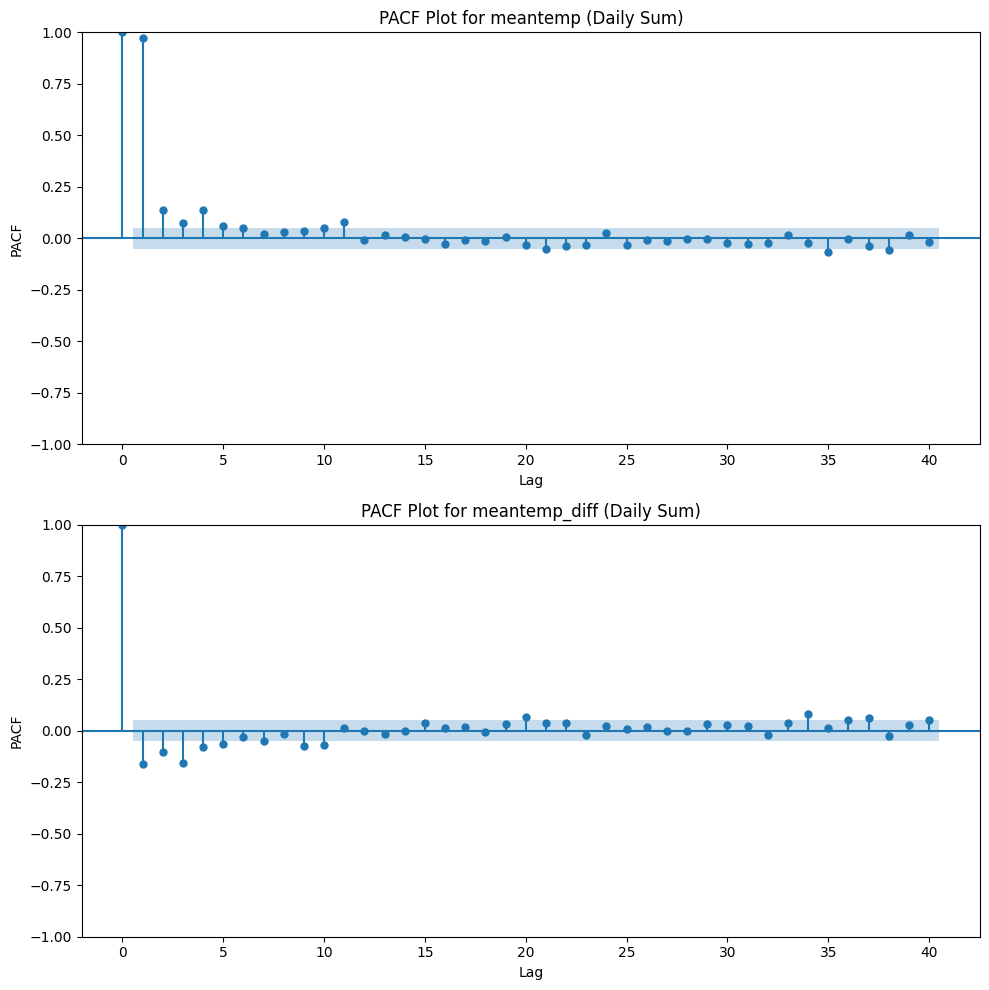

In [20]:
columns = ['meantemp', 'meantemp_diff']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 5 * len(columns)))
axes = axes.flatten()

for i, col in enumerate(columns):
  ax = axes[i]
  plot_pacf(x=df1[col], ax=ax, lags=40)
  ax.set_title(f'PACF Plot for {col} (Daily Sum)')
  ax.set_xlabel('Lag')
  ax.set_ylabel('PACF')

plt.tight_layout()
plt.show()

In [21]:
df_arima = df_model[['date','meantemp']].copy()
df_arima['date'] = pd.to_datetime(df_arima['date'])
df_arima = df_arima.resample('D', on='date').mean()
df_arima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meantemp  1462 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


## Train Test Split

In [22]:
train_size = int(len(df_arima) * 0.8)
train, test = df_arima.iloc[:train_size], df_arima.iloc[train_size:]

## Arima

In [23]:
model = ARIMA(train['meantemp'], order=(1,1,1))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1169
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2213.194
Date:                Sat, 20 Jul 2024   AIC                           4432.388
Time:                        15:51:51   BIC                           4447.577
Sample:                    01-01-2013   HQIC                          4438.117
                         - 03-14-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5751      0.053     10.942      0.000       0.472       0.678
ma.L1         -0.7968      0.042    -18.912      0.000      -0.879      -0.714
sigma2         2.5901      0.079     32.851      0.0

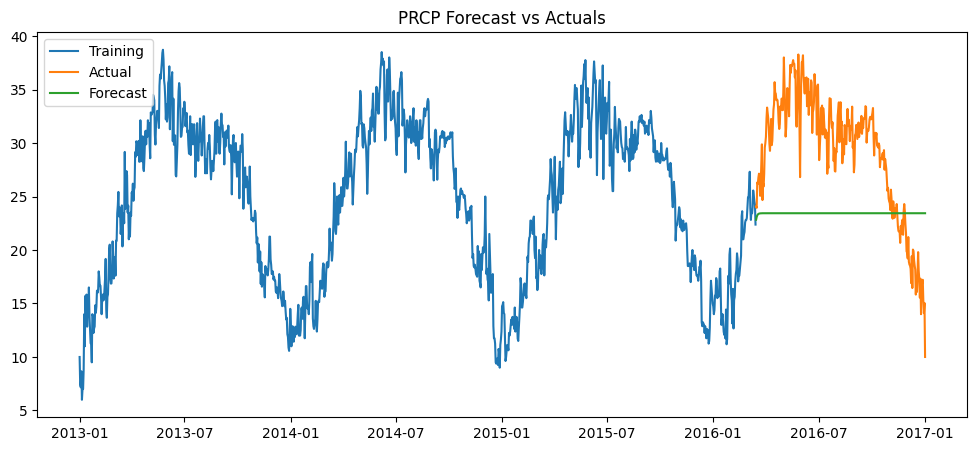

In [24]:
forecast_steps = len(test)
forecast = fitted_model.forecast(steps = forecast_steps)
forecast_series = pd.Series(forecast, index = test.index)

plt.figure(figsize=(12, 5))
plt.plot(train, label='Training')
plt.plot(test, label='Actual')
plt.plot(forecast_series, label='Forecast')
plt.title('PRCP Forecast vs Actuals')
plt.legend(loc='upper left')
plt.show()

In [25]:
def forecast_accuracy(forecast, actual):
  mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
  mae = np.mean(np.abs(forecast - actual))
  rmse = np.sqrt(np.mean((forecast - actual)**2))
  smape = 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(forecast) + np.abs(actual)))

  return mape, mae, rmse, smape

mape, mae, rmse, smape = forecast_accuracy(forecast, test.values.flatten())
print(f"MAPE: {mape}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"SMAPE: {smape}")

MAPE: 0.24534740544815015
MAE: 7.274058180544291
RMSE: 8.102417056421306
SMAPE: 26.967922993050784
